In [2]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
from acoustic_entrainment import VelocityResponse, muflown_response, muflown_sensitivity, mic_response
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from brownian import abc_guess, get_krhoA, psd_func, logbin_func, get_sound_speed, psd_abc_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import numpy as np

from os import path

from matplotlib import rc
fontsize = 10
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
    "text.latex.preamble":r'\usepackage{upgreek}' 
}

plt.rcParams.update(fontstyle)
letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)


# New function definitions

In [3]:
def sort_fnames(fnames, include=None, exclude=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    if exclude is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr not in exclude]
    return fnames_sorted

from constants import kB
from scipy.integrate import cumulative_trapezoid

reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

def psd_calibration(fname, channel="X",
                   fmin=5e2, fmax=4e4, cutoff=1e6,  taumax=100e-3,freq_xnoise2=2e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    C = Collection(fname)
    C.set_collection(channel)
    C.R = 1.51e-6
    Tavg = np.mean(C.T)
    if Tavg < 273.15:
        Tavg += 273.15
    Npts = int(C.r / (2*cutoff))
    C.apply("detrend", inplace=True, mode="constant")
    #C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    
    fun = make_objective(psd_abc_func, freq[mask], psd[mask], C.Navg_psd)
    res = minimize(fun, abc, method="Nelder-Mead")
    abc = res.x
    
    cal_params = get_params_from_abcRT(*abc, C.R, Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>freq_xnoise2])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker="o", ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq[1:], plot_psd[1:], **dplot_kwargs)
        
        fplot_kwargs = dict(c=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        #ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

def deg2rad(x):
    return x * np.pi / 180


def rad2deg(x):
    return x * 180 / np.pi

def radian_labels(ax, denoms=[-1, -2, 0, 2, 1], skip=1):
    rads = [np.pi/d if d!=0 else 0 for d in denoms]
    rad_labels = [r"$-\pi/%s$" % abs(d) if d<-1 \
             else r"$\pi/%s$" % abs(d) if d>1 \
             else "$-\pi$" if d == -1 \
             else "$\pi$" if d == 1 \
             else "$0$" for d in denoms]
    return rads, rad_labels
    

def dB_re(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return deci * np.log10(x/ref)

def db_re_inverse(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return ref * 10**(x/deci)


def SPL(x):
    return dB_re(x, ref=20e-6, typ="pressure")


def slope(x, m):
    return x/m

def line(x, speed, x0):
    return (x-x0)/speed

def slope_quad(x, a, b):
    return a*x + b*x*x

def powerlaw(x, a, m):
    return a * x**m

def exponential(x, a, m):
    return a * np.e**(x/m)

def find_pulse_points(time_series, tmin, tmax, factor=0.0, nozeros=False): 
    ts, xs = time_series.time_gate(tmin, tmax)
    # trough
    troughdex = np.argmin(xs)
    ttrough = ts[troughdex]
    xtrough = xs[troughdex]
    #peak
    peakdex = np.argmax(xs[ts<ttrough])
    tpeak = ts[ts<ttrough][peakdex]
    xpeak = xs[ts<ttrough][peakdex]
    if nozeros:
        tpoints = [0, tpeak, 0, ttrough, 0]
        xpoints = [0, xpeak, 0, xtrough, 0]
        return tpoints, xpoints
        
    # zeros
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xpeak)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    ## left
    peak_minus_zeros = tpeak - tzeros
    left_zeros_mask = peak_minus_zeros > 0
    left_zero = tzeros[left_zeros_mask][np.argmin(peak_minus_zeros[left_zeros_mask])]
    ## right
    pre_zerodex = np.where(np.diff(np.sign(xs-factor*xtrough)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    zeros_minus_trough = tzeros - ttrough
    right_zeros_mask =  zeros_minus_trough > 0
    right_zero = tzeros[right_zeros_mask][np.argmin(zeros_minus_trough[right_zeros_mask])]
    ## middle
    pre_zerodex = np.where(np.diff(np.sign(xs)))[0]
    post_zerodex = 1 + pre_zerodex
    t1, t2 = ts[pre_zerodex], ts[post_zerodex]
    x1, x2 = xs[pre_zerodex], xs[post_zerodex]
    tzeros = t1 - x1*((t2-t1)/(x2-x1))
    mid_zero = tzeros[np.logical_and(tzeros>tpeak, tzeros<ttrough)][0]
    # important points
    tpoints = [left_zero, tpeak, mid_zero, ttrough, right_zero]
    xpoints = [factor*xpeak, xpeak, 0, xtrough, factor*xtrough]
    return tpoints, xpoints


def make_musphere_response(C0, impedance=None, r0=3e-2, response="bassetbound"):
    T = np.mean(C0.T)
    VR = VelocityResponse(1/C0.cal, C0.R, C0.rho, T, C0.k,C0.cRH)
    if impedance is None:
        _response = lambda f:VR.response(response, f)
    else:
        impedance = getattr(VR, f"{impedance}_impedance")
        _response = lambda f:VR.response(response, f)/impedance(f, r0)
    return _response



def load_collection(fname, channel, response, differentiate, 
                    scale=1, cutoff=None, Npts="cutoff", shift=0, invert=False, 
                    tmin=None, tmax=None, window="boxcar", detrend="constant"):
    C = Collection(fname)
    C.set_collection(channel)
    C.apply("calibrate", cal=scale, inplace=True)
    if cutoff is not None:
        C.apply("lowpass", cutoff=cutoff, inplace=True)
    if Npts is not None:
        if Npts == "cutoff":
            if cutoff is not None:
                Npts=int(C.r/(2*cutoff))
            else:
                Npts = None
        C.apply("bin_average", Npts=Npts, inplace=True)
    if response is not None:
        C.apply("correct", response=response, n_jobs=1, tmin=tmin, tmax=tmax, 
            window=window, differentiate=differentiate, recollect=True)
    if response is None and differentiate:
        C.apply("differentiate", inplace=True)
        
    if detrend is not None:
        C.apply("detrend", mode=detrend, inplace=True)
    C.apply("shift", tau=shift, inplace=True)
    if invert:
        C.apply("calibrate", cal=-1, inplace=True)
    return C

def make_objective(model, freq, psd, n):
    """ Construct negative log-likelihood objective function"""
    #c = np.sum(np.log(gamma(n)) - n*np.log(n)-(n-1)*np.log(psd))
    def objective(popts):
        model_psd = model(freq, *popts)
        obj = n*np.sum(np.log(model_psd) + psd/model_psd)
        #obj+=c
        return obj
    return objective
       

# Directory structure

In [4]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20220707',
 '/data/brownian/20211215',
 '/data/brownian/20220720',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20221019',
 '/data/brownian/20220525',
 '/data/brownian/20220614',
 '/data/brownian/20220628',
 '/data/brownian/20220726',
 '/data/brownian/20220722',
 '/data/brownian/20220715',
 '/data/brownian/20220523']

In [4]:
# Select a date
date_der_index = 7
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20220715/bead1']

In [5]:
# Select a date
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20220715/bead1/slow_phone_40kHz-pos-scan-0-20',
 '/data/brownian/20220715/bead1/slow_phone_40kHz-fos-scan-30-200',
 '/data/brownian/20220715/bead1/slow_flown_40kHz-pos-scan-0-20',
 '/data/brownian/20220715/bead1/slow_flown_baseline2',
 '/data/brownian/20220715/bead1/slow_phone_baseline',
 '/data/brownian/20220715/bead1/slow_flown_40kHz-fos-scan-30-200',
 '/data/brownian/20220715/bead1/slow_phone_40kHz-logfos-scan-30-200_moved']

# Bead calibration

In [6]:
baseline_experiment_index = (3,4)
baseline_fnames = find_files(experiment_ders[baseline_experiment_index[0]])
for experiment_der_index in baseline_experiment_index[1:]:
    next_fnames = find_files(experiment_ders[experiment_der_index])
    for fname in next_fnames:
        baseline_fnames.append(fname)

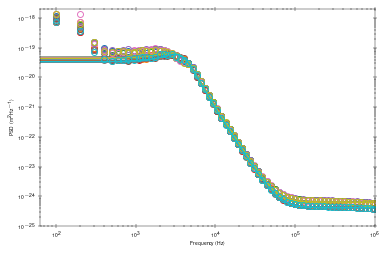

In [7]:
fmin = 2e3
fmax = 3e4
cutoff = 1000e3
taumax = 10e-3

fig, ax = plt.subplots(1,1, figsize=(6,4))

krhoCalTs = []
for fnamei, fname in enumerate(sort_fnames(baseline_fnames)):
    color = f"C{fnamei}"
    C0, ax = psd_calibration(fname, taumax=taumax, fmin=fmin, fmax=fmax, cutoff=cutoff, 
                             plot=True, ax=ax, color=color)
    krhoCalTs.append([C0.k, C0.rho, C0.cal, C0.Tavg])    
krhoCalTs = np.array(krhoCalTs)

k : 14.199285348777213 0.30029996256884617 2.114894906275736
rho : 1522.3132574289095 13.462417456614547 0.8843395004883369
cal : 1.6334120530549516 0.015651179367994504 0.9581892908603364
T : 24.366663097019995 0.006369173703487814 0.026138883597347205


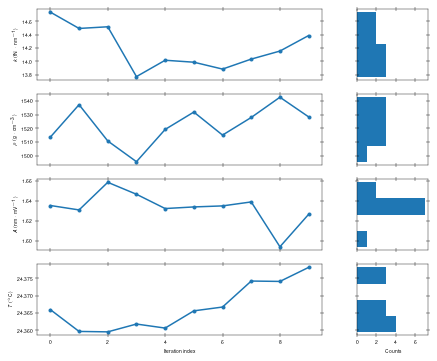

In [8]:
fig, axs = plt.subplots(4,2, figsize=(7, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "cal", "T"]):
    vals = krhoCalTs[::2, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="cal":
        vals = vals * 1e9 / 1e3
    if param == "T":
        vals = vals -273.15
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))
k, rho, cal, _ = np.mean(krhoCalTs, axis=0)
R = C0.R

musphere_response = make_musphere_response(C0, response="bassetbound", impedance="plane", r0=0)

In [15]:
bd_cutoff = 200e3
taumax = 50e-3
fname0_ph = sort_fnames(baseline_fnames)[-1]
fname0_fl = sort_fnames(baseline_fnames)[0]


In [16]:
Cbd0 = load_collection(fname0_ph, "X", musphere_response, 
                  differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=0, invert=False)

Cph0 = load_collection(fname0_ph, "Y", mic_response, 
                  differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=0, invert=False)

Cfl0 = load_collection(fname0_fl, "Y", muflown_response, 
                  differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=0, invert=False)
Cbd0.average("PSD", taumax=taumax)
Cph0.average("PSD", taumax=taumax)
Cfl0.average("PSD", taumax=taumax)
Cfl0.r

409836.06557377044

# Drive frequency scan

In [17]:
fnames_ph = sort_fnames(find_files(experiment_ders[1]))
fnames_fl = sort_fnames(find_files(experiment_ders[5]))

In [18]:
foss = []
for fname in fnames_ph:
    C = Collection(fname)
    foss.append(C.fos)
foss = np.array(foss)

Cbds_ph = np.zeros(len(foss), dtype="object")
Cphs_ph = np.zeros(len(foss), dtype="object")
fnamei = 0
for fosi, fos in enumerate(foss):
    fname = fnames_ph[fnamei]
    Cbd = load_collection(fname, "X", musphere_response, 
                  differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=0, invert=False)
    Cph = load_collection(fname, "Y", mic_response, 
                  differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=25.5e-6, invert=False)
    Cbd.average("PSD", taumax=taumax)
    Cph.average("PSD", taumax=taumax)
    fnamei += 1
    Cbds_ph[fosi] = Cbd
    Cphs_ph[fosi] = Cph        
    
    
Cbds_fl = np.zeros(len(foss), dtype="object")
Cfls_fl = np.zeros(len(foss), dtype="object")
fnamei = 0
for fosi, fos in enumerate(foss):
    fname = fnames_fl[fnamei]
    Cbd = load_collection(fname, "X", musphere_response, 
                  differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=0, invert=False)
    Cfl = load_collection(fname, "Y", muflown_response, 
                  differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=25.5e-6, invert=False)
    Cbd.average("PSD", taumax=taumax)
    Cfl.average("PSD", taumax=taumax)
    fnamei += 1
    Cbds_fl[fosi] = Cbd
    Cfls_fl[fosi] = Cfl   

30000.0 12134.21986970285
30000.0 149.52849556457105
30000.0 21.17437809759065
33469.38775510204 180085.96113949054
33469.38775510204 908.9459866461027
33469.38775510204 506.1993691504262
36938.77551020408 1251215.0369511945
36938.77551020408 1965.8357386484686
36938.77551020408 850.7488627574998
40408.163265306124 33914114.06592466
40408.163265306124 1232.0535276205399
40408.163265306124 130936.72668217924
43877.551020408166 7456496.272625693
43877.551020408166 26447.05914195677
43877.551020408166 20070.512230625514
47346.9387755102 3553763.403452146
47346.9387755102 13701.533104651731
47346.9387755102 4009.0896369133225
50816.32653061224 1383458.7501215849
50816.32653061224 1426.51333256912
50816.32653061224 1175.3144670157099
54285.71428571428 1073748.9450230023
54285.71428571428 2814.360447012054
54285.71428571428 299.30555073176015
57755.102040816324 1257076.280253937
57755.102040816324 2731.5621088441717
57755.102040816324 1122.4692545055732
61224.48979591837 993045.5620509998
61

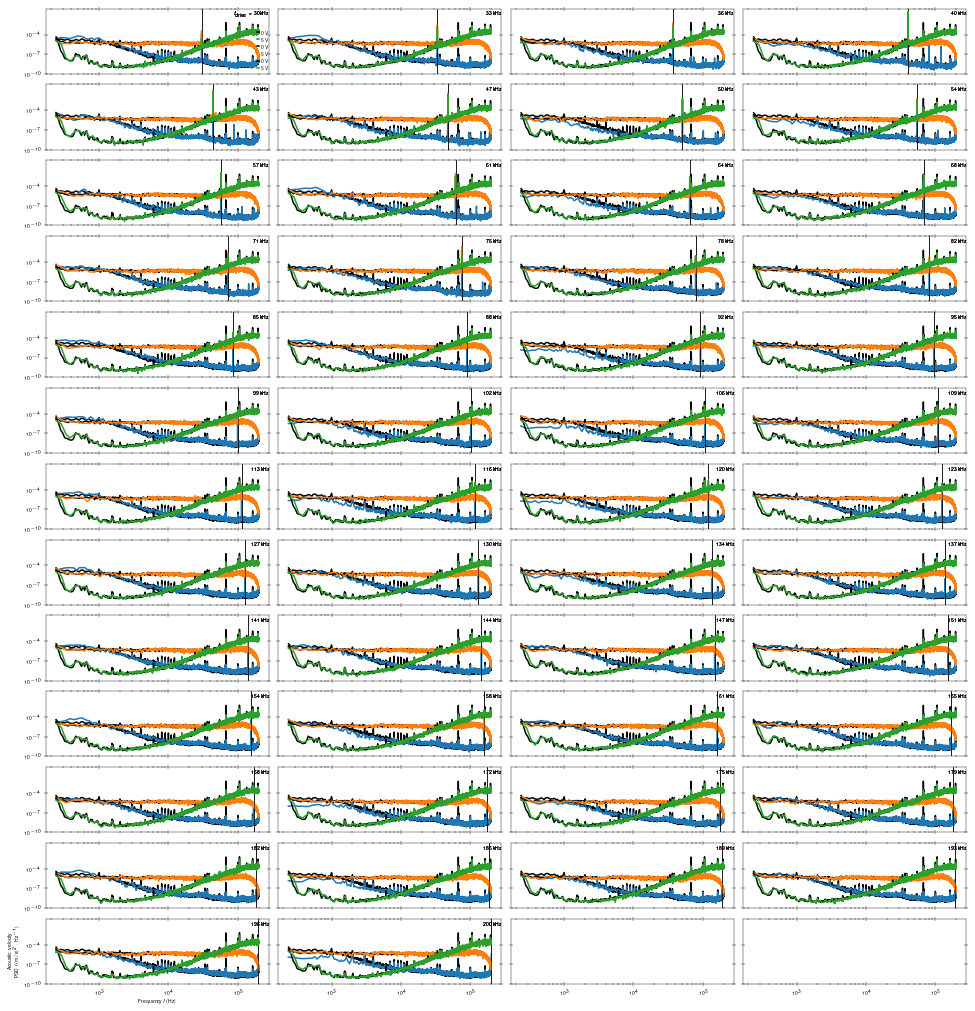

In [19]:
Deltaf = 500
cutoff = bd_cutoff
Nrow, Ncol = len(foss)//4+1, 4
fig, axs = plt.subplots(Nrow, Ncol, figsize=(4*3.375, 14), sharex=True, sharey=True)

SNRs = np.zeros((3, len(foss)))
for fosi, fos in enumerate(foss):
    fos *= 1e3
    r = fosi // Ncol
    c = fosi % Ncol
    ax = axs[r, c]
    #inax = ax.inset_axes((0, 0.5, 0.5, 0.5))
    for Ci, (Cs, C0) in enumerate(zip([Cphs_ph, Cbds_ph, Cfls_fl], [Cph0, Cbd0, Cfl0])):
        if C0 == Cfl0:
            factor = 410
        else:
            factor = 1
            
        C = Cs[fosi]
        color = f"C{Ci}"


        mask0 = np.logical_and(C0.freq<cutoff, C0.freq>230)
        inmask0 = np.logical_and(C0.freq>fos-Deltaf/2, C0.freq<min(fos+Deltaf/2, 2.0e6))
        ax.loglog(C0.freq[mask0], factor*factor*C0.psd[mask0], c="k", label="0 V")
        #inax.plot(C0.freq[inmask0]-fos, C0.psd[inmask0]*1e6, marker=".", c="k")
        ax.axvline(fos, lw=0.5, c="k")


        freq, psd = C.freq, C.psd

        inmask = np.logical_and(freq>fos-Deltaf/2, freq<min(fos+Deltaf/2, 2.0e6))

        mask = np.logical_and(freq<cutoff, freq>230)
        ax.loglog(freq[mask], factor*factor*psd[mask], label="5 V", c=color)
        #inax.plot(freq[inmask]-fos, psd[inmask]*1e6, marker=".", c=color)
        max_dex = np.argmax(psd[inmask])
        mx = factor*factor*psd[inmask][max_dex]
        mn = factor*factor*C0.psd[inmask0][max_dex]
        SNR = mx/mn
        SNRs[Ci, fosi] = SNR
        print(fos, SNR)
        if c==0 and r==0:
            drive_str = r"$f_{\rm drive} = %s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"${\rm SNR} = %s$ dB" % (round(10*np.log10(mx/mn),1))
        else:
            drive_str = r"$%s$ kHz" % (int(fos/1e3)) 
            SNR_str = r"$%s$ dB" % (round(10*np.log10(mx/mn),1))

        ax.text(1, 0.96, drive_str, transform=ax.transAxes, va="top", ha="right")
        #inax.text(1, 0.96, SNR_str, transform=inax.transAxes, va="top", ha="right")
        #inax.set_yticks([])
        #inax.set_xticks([-100, 0, 100])
        #inax.set_xlabel(r"$f-f_{\rm drive}$ (Hz)", labelpad=0)
#axs[-1,0].set_yscale("log")
axs[-1, 0].set_yticks([1e-10, 1e-7, 1e-4])
axs[-1, 0].set_xlabel(r"Frequency $f$ (Hz)")
axs[-1, 0].set_ylabel("Acoustic velocity\n"+ r"PSD $\rm ((m/s)^2 \cdot Hz^{-1})$")
axs[0, 0].legend(frameon=False, handlelength=0.3, handletextpad=0.5, loc="lower right", bbox_to_anchor=(1.02, -0.02))
plt.tight_layout()
#plt.savefig("figures/shaker_PSD_peaks.pdf", bbox_inches="tight")
dB_SNRs = 10*np.log10(SNRs)

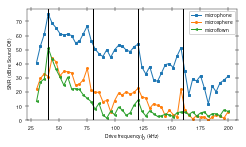

In [20]:

fig, ax = plt.subplots(1 ,1, figsize=(3.375, 2))
ax.plot(foss, dB_SNRs[0, ], marker="s", ms=2, lw=1, label="microphone") 
ax.plot(foss, dB_SNRs[1, ], marker="o", ms=2, lw=1, label="microsphere")
ax.plot(foss, dB_SNRs[2, ], marker="<", ms=2, lw=1, label="microflown") 
ax.set_ylim(bottom=0)
for n in (1,2,3,4):
    plt.axvline(n*40, lw=1, c="k")
ax.legend()
ax.set_ylabel("SNR (dB re Sound Off)")
ax.set_xlabel("Drive frequency $f_0$ (kHz)")
plt.tight_layout()
#plt.savefig("figures/40kHz-CW-fos-scan_SNR.pdf")

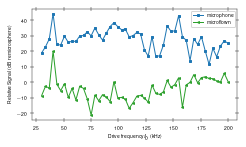

In [21]:
fig, ax = plt.subplots(1 ,1, figsize=(3.375, 2))
ax.plot(foss, dB_SNRs[0, ]-dB_SNRs[1, ], marker="s", c="C0", ms=2, lw=1, label="microphone") 
ax.plot(foss, dB_SNRs[2, ]-dB_SNRs[1, ], marker="<", c="C2", ms=2, lw=1, label="microflown") 
#ax.set_ylim(bottom=0)
ax.legend()
ax.set_ylabel("Relative Signal (dB re microsphere)")
ax.set_xlabel("Drive frequency $f_0$ (kHz)")
plt.tight_layout()
#plt.savefig("figures/40kHz-CW-fos-scan_SNR-ratios.png", dpi=600)

Text(0, 0.5, 'Pressure (Pa)')

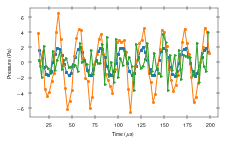

In [22]:

tmin=13e-6
tmax=200e-6
recordi=9

fig, ax = plt.subplots(1,1, figsize=(3.375, 2))

Cbd = Cbds_ph[4]
Cph = Cphs_ph[4]
Cfl = Cfls_fl[4]
Cbd.aggrigate()
Cph.aggrigate()
Cfl.aggrigate()

if recordi == "avg":
    Dbd = Cbd.agg
    Dph = Cph.agg
    Dfl = Cfl.agg
else: 
    Dbd = Cbd.collection[recordi]
    Dph = Cph.collection[recordi]
    Dfl = Cfl.collection[recordi]
    
Dph.plot(ax=ax, tmin=tmin, tmax=tmax, tunit="us", marker="s", c="C0", ms=2, lw=1, label="microphone")
Dbd.plot(ax=ax,  tmin=tmin, tmax=tmax, tunit="us", marker="o", c="C1", ms=2, lw=1, label="micosphere")
Cfl.agg.plot(ax=ax, tmin=tmin, tmax=tmax, tunit="us", unit=1/410, marker=">", c="C2", ms=2, lw=1, label="microflown")
#ax.legend()
ax.set_ylabel("Pressure (Pa)")
#plt.savefig("figures/40kHz-CW-fos-resonance_time-series.png", dpi=600)

# Distace scan

In [27]:
bd_cutoff = 200e3
taumax = 50e-3
fnames_ph = sort_fnames(find_files(experiment_ders[0]))
fnames_fl = sort_fnames(find_files(experiment_ders[2]))

In [28]:
poss = []
for fname in fnames_ph:
    C = Collection(fname)
    poss.append(C.pos)
poss = np.array(poss)
abs_pos = poss + 4.4

Cbds_ph = np.zeros(len(poss), dtype="object")
Cphs_ph = np.zeros(len(poss), dtype="object")
fnamei = 0
for posi, pos in enumerate(poss):
    fname = fnames_ph[fnamei]
    Cbd = load_collection(fname, "X", musphere_response, 
                  differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=0, invert=False)
    Cph = load_collection(fname, "Y", mic_response, 
                  differentiate=False, cutoff=200e3, Npts=int(25e6/(2*200e3)), shift=25.5e-6, invert=False)
    Cbd.average("PSD", taumax=taumax)
    Cph.average("PSD", taumax=taumax)
    fnamei += 1
    Cbds_ph[posi] = Cbd
    Cphs_ph[posi] = Cph        
    
    
Cbds_fl = np.zeros(len(poss), dtype="object")
Cfls_fl = np.zeros(len(poss), dtype="object")
fnamei = 0
for posi, pos in enumerate(poss):
    fname = fnames_fl[fnamei]
    Cbd = load_collection(fname, "X", musphere_response, 
                  differentiate=True, cutoff=bd_cutoff, Npts="cutoff", shift=0, invert=False)
    Cfl = load_collection(fname, "Y", muflown_response, 
                  differentiate=False, cutoff=100e3, Npts=int(25e6/(2*200e3)), shift=25.5e-6, invert=False)
    Cbd.average("PSD", taumax=taumax)
    Cfl.average("PSD", taumax=taumax)
    fnamei += 1
    Cbds_fl[posi] = Cbd
    Cfls_fl[posi] = Cfl   

<ipython-input-38-71e13f35138f>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(3.375, 2))


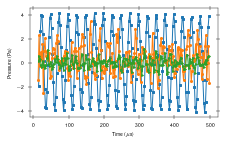

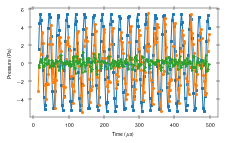

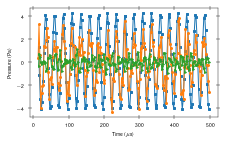

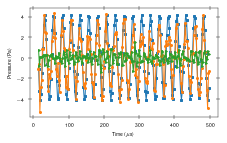

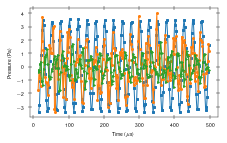

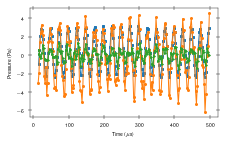

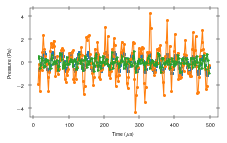

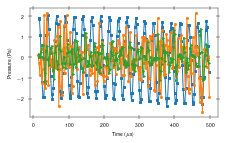

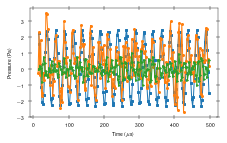

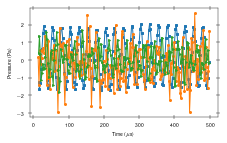

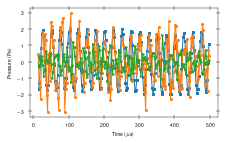

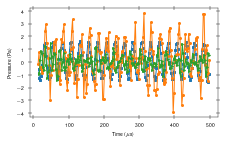

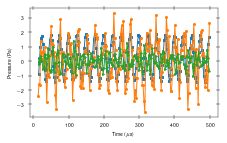

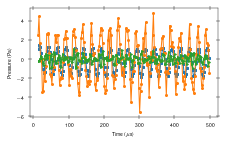

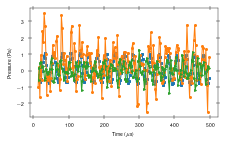

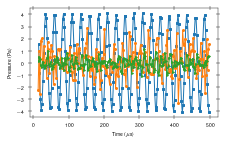

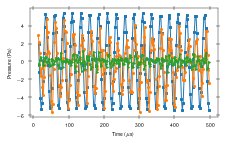

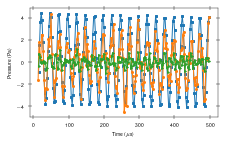

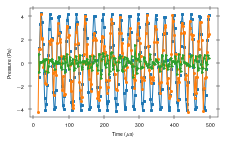

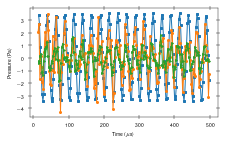

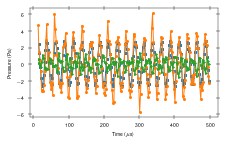

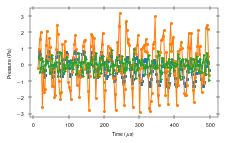

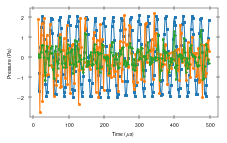

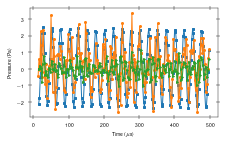

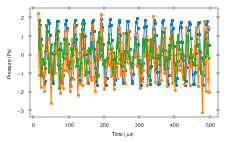

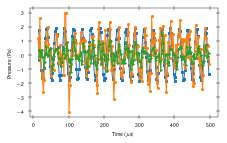

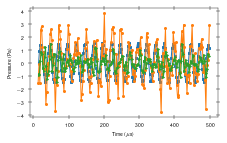

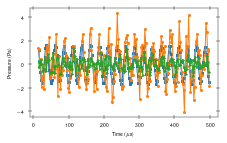

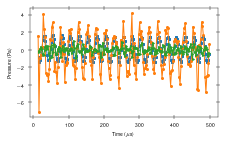

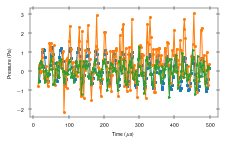

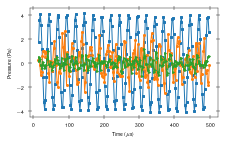

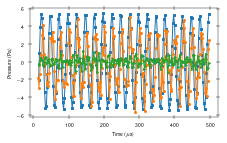

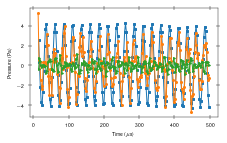

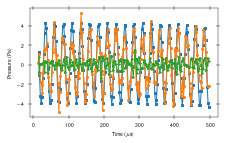

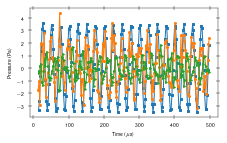

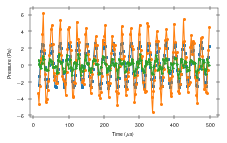

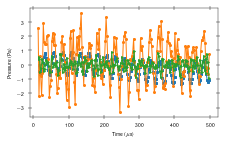

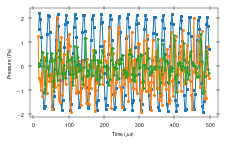

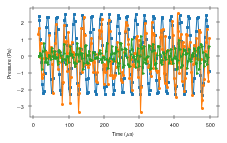

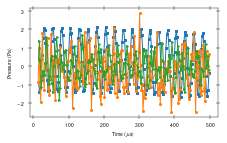

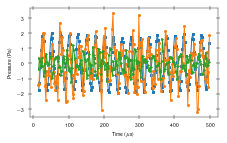

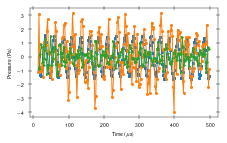

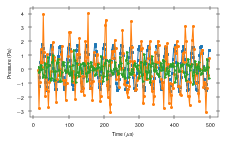

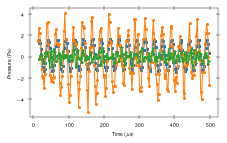

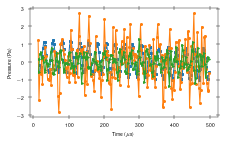

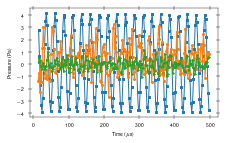

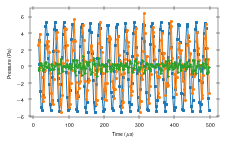

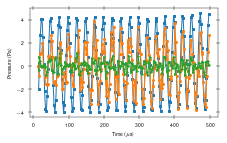

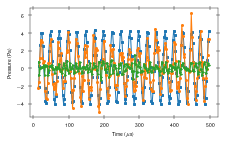

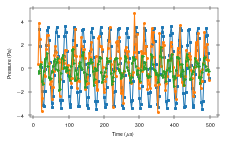

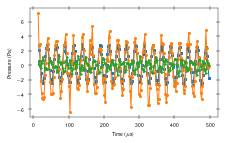

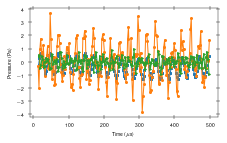

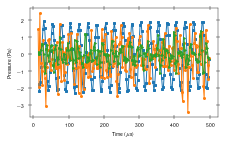

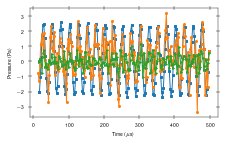

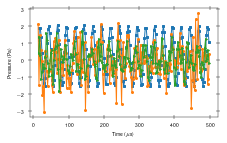

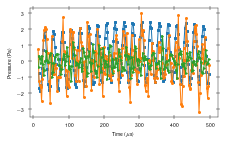

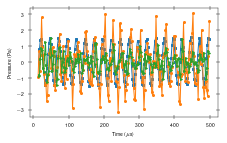

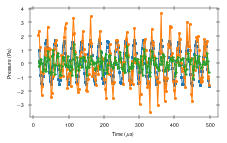

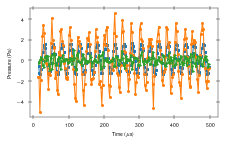

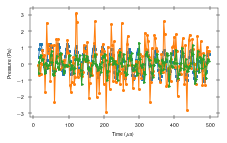

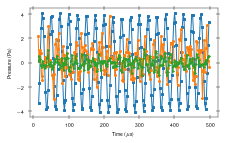

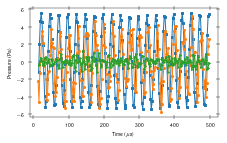

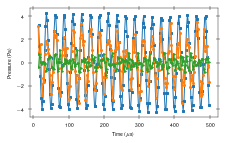

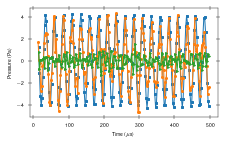

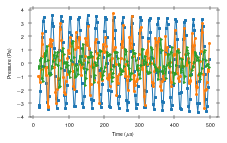

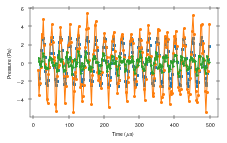

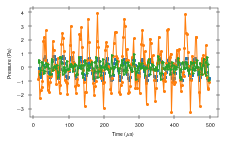

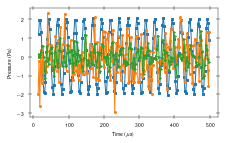

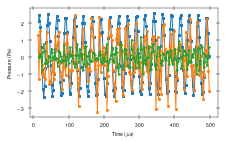

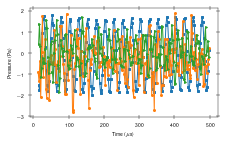

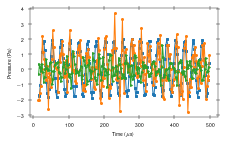

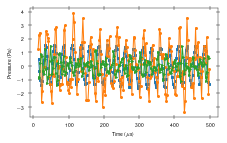

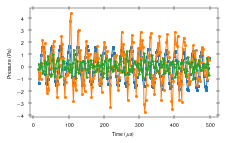

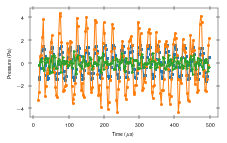

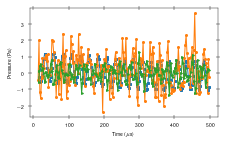

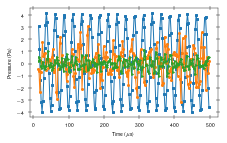

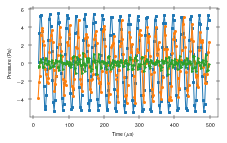

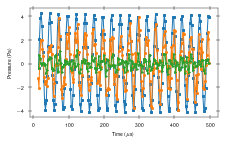

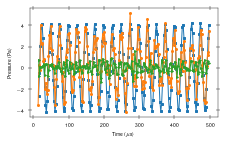

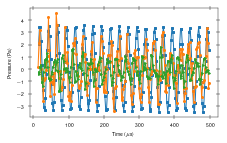

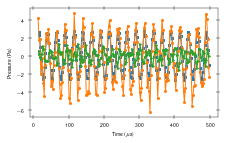

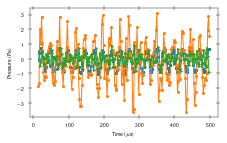

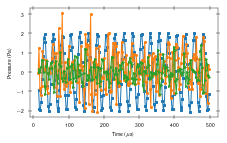

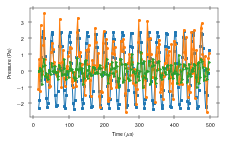

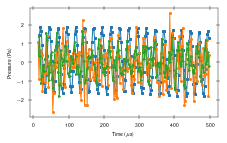

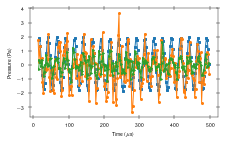

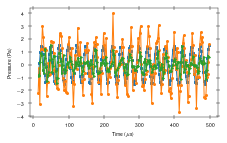

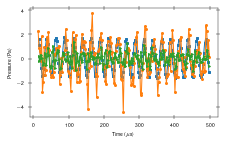

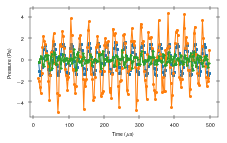

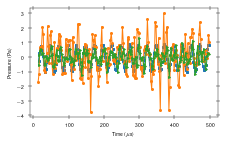

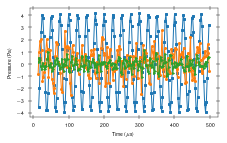

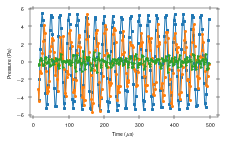

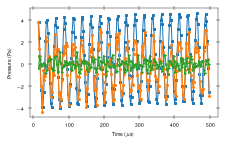

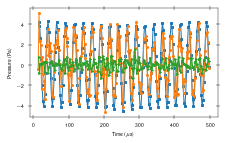

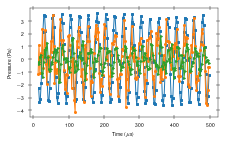

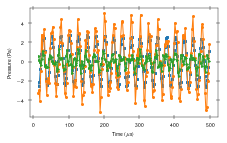

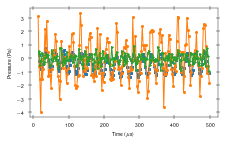

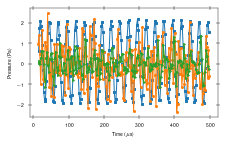

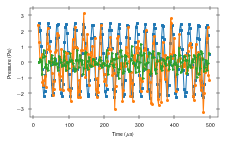

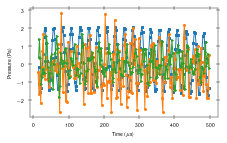

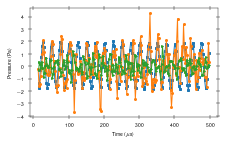

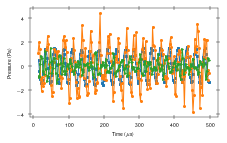

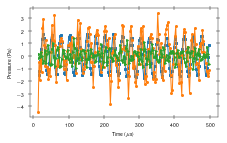

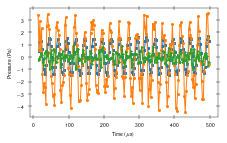

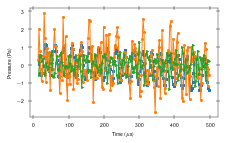

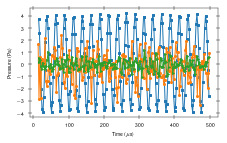

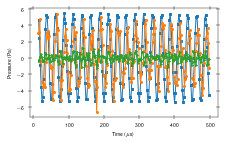

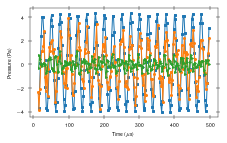

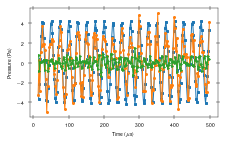

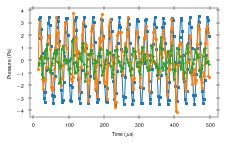

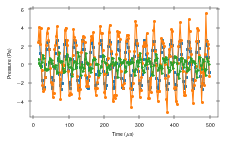

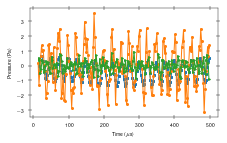

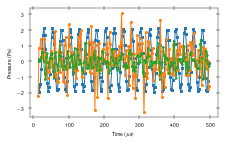

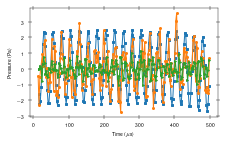

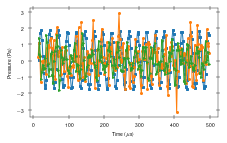

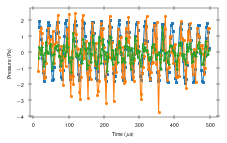

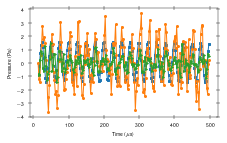

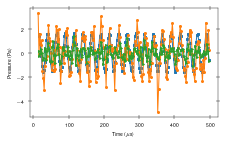

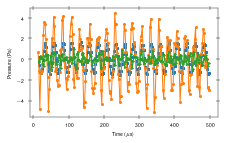

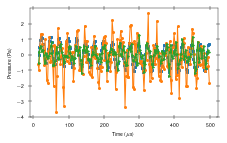

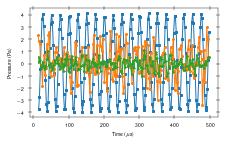

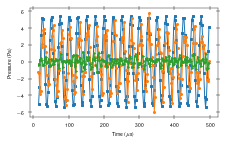

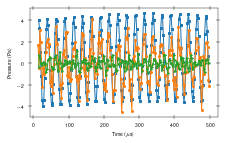

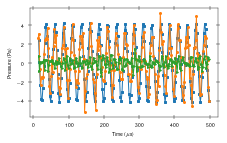

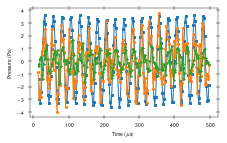

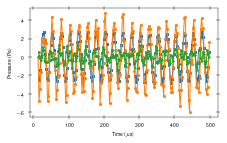

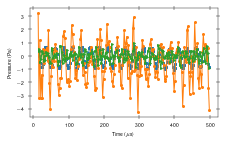

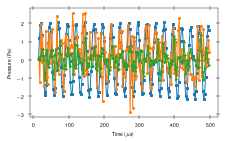

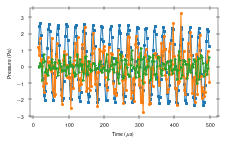

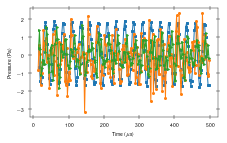

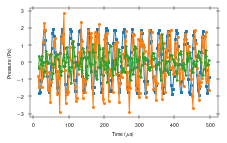

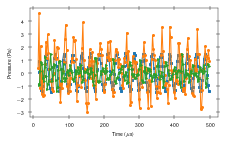

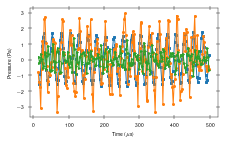

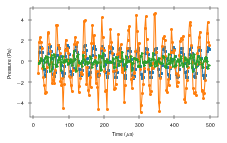

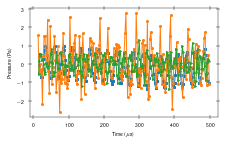

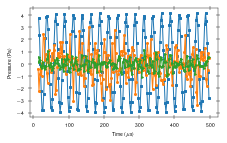

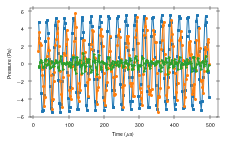

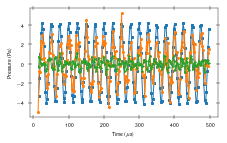

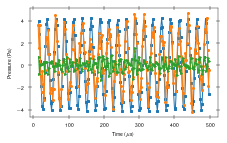

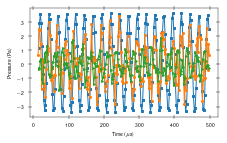

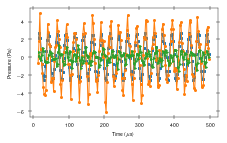

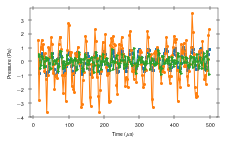

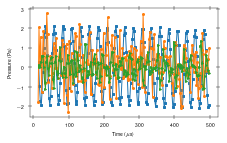

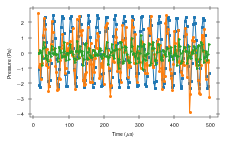

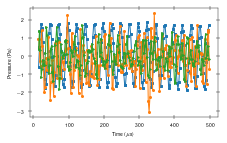

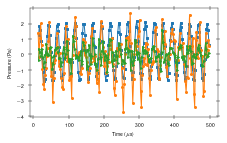

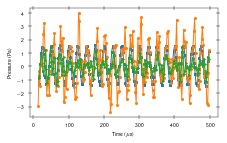

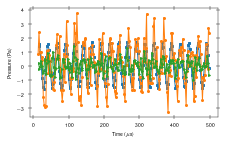

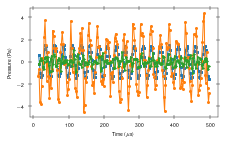

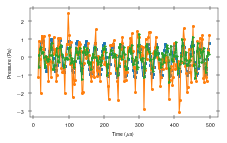

In [38]:

tmin=13e-6
tmax=500e-6
RMSs = np.zeros((3, len(poss), 10))
for recordi in range(10):
    for posi, pos in enumerate(poss):
        fig, ax = plt.subplots(1,1, figsize=(3.375, 2))
        Cbd = Cbds_ph[posi]
        Cph = Cphs_ph[posi]
        Cfl = Cfls_fl[posi]
        Cbd.aggrigate()
        Cph.aggrigate()
        Cfl.aggrigate()

        if recordi == "avg":
            Dbd = Cbd.agg
            Dph = Cph.agg
            Dfl = Cfl.agg
        else: 
            Dbd = Cbd.collection[recordi]
            Dph = Cph.collection[recordi]
            Dfl = Cfl.collection[recordi]

        bdrms = np.mean(Dbd.x[10:]**2)
        phrms = np.mean(Dph.x[10:]**2)
        flrms = np.mean((Dfl.x[10:]*410)**2)

        RMSs[:, posi, recordi] = [phrms, bdrms, flrms]

        Dph.plot(ax=ax, tmin=tmin, tmax=tmax, tunit="us", marker="s", c="C0", ms=2, lw=1, label="microphone")
        Dbd.plot(ax=ax,  tmin=tmin, tmax=tmax, tunit="us", marker="o", c="C1", ms=2, lw=1, label="micosphere")
        Cfl.agg.plot(ax=ax, tmin=tmin, tmax=tmax, tunit="us", unit=1/410, marker=">", c="C2", ms=2, lw=1, label="microflown")

        #ax.legend()
        ax.set_ylabel("Pressure (Pa)")
        #plt.savefig("figures/40kHz-CW-fos-resonance_time-series.png", dpi=600)

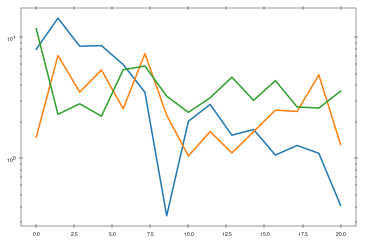

In [41]:

plt.semilogy(poss, np.mean(RMSs, axis=2).T)